In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
import matplotlib
import gpanim
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
seed = 124
np.random.seed(seed)

In [3]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')

In [4]:
# load in observational data
current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')
voltage_file_targets = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000r.txt')
voltage_file_empty = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006r.txt')
voltage_file_targets_quad = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000q.txt')
voltage_file_empty_quad = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006q.txt')


experiments = []
quadratures = []
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages_targets = voltage_file_targets[32*i+1:32*(i+1)+1]
    this_voltages_empty = voltage_file_empty[32*i+1:32*(i+1)+1]
    this_voltages_targets_quad = voltage_file_targets_quad[32*i+1:32*(i+1)+1]
    this_voltages_empty_quad = voltage_file_empty_quad[32*i+1:32*(i+1)+1]
    experiments.append((this_currents.reshape((32,1)), this_voltages_targets.reshape((32,1)), this_voltages_empty.reshape((32,1))))
    quadratures.append((this_voltages_targets_quad.reshape((32,1)), this_voltages_empty_quad.reshape((32,1))))

In [5]:
kappa = sp.Function('kappa')(x_1, x_2)
kappa_x_1 = sp.Function('kappa_x1')(x_1, x_2)
kappa_x_2 = sp.Function('kappa_x2')(x_1, x_2)
kappa_bar = sp.Function('kappabar')(y_1, y_2)
kappa_y_1_bar = sp.Function('kappabar_y1')(y_1, y_2)
kappa_y_2_bar = sp.Function('kappabar_y2')(y_1, y_2)

In [193]:
length_scale = 0.2
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))

A = lambda k: sp.exp(kappa)*(kappa_x_1 * k.diff(x_1) + kappa_x_2 * k.diff(x_2) + k.diff(x_1, x_1) + k.diff(x_2, x_2))
A_bar = lambda k: sp.exp(kappa_bar)*(kappa_y_1_bar * k.diff(y_1) + kappa_y_2_bar * k.diff(y_2) + k.diff(y_1, y_1) + k.diff(y_2, y_2))

B = lambda k: sp.exp(kappa) * (k.diff(x_1)*x_1 + k.diff(x_2)*x_2)
B_bar = lambda k: sp.exp(kappa_bar) * (k.diff(y_1)*y_1 + k.diff(y_2)*y_2)

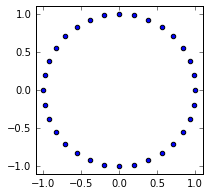

In [194]:
# there are 32 evenly spaced electrodes between 0 and 2\pi
# the electrodes go counter-clockwise from the +x axis and finish at x=1, y=0
electrodes = np.linspace(0, 2*np.pi, 33)[1:-1]
electrodes = np.append(electrodes,0)
electrode_x = np.cos(electrodes)
electrode_y = np.sin(electrodes)
plt.figure(figsize=(3,3))
plt.scatter(electrode_x, electrode_y)
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

bdy = np.c_[electrode_x, electrode_y]

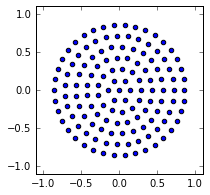

In [195]:
# we also need a few interior points
radii = np.linspace(0,1,8)[1:-1]
r_spacing = radii[1] - radii[0]
coords = [np.array([[0.,0.]])]
for r in radii:
    # we want the number of theta which 
    n_theta = np.round(2*np.pi*r / r_spacing)
    thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
    x = np.cos(thetas)
    y = np.sin(thetas)
    coords.append(r*np.c_[x,y])
coords = np.concatenate(coords)

plt.figure(figsize=(3,3))
plt.scatter(coords[:,0], coords[:,1])
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

interior = coords

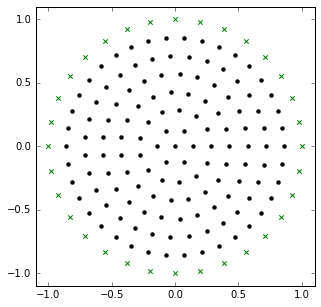

In [196]:
plt.figure(figsize=(5,5))
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
plt.scatter(bdy[:,0], bdy[:,1], marker='x', c='green')
plt.scatter(interior[:,0], interior[:,1], linewidth=0, c='black')

In [197]:
field_pts = np.r_[interior, bdy]

In [198]:
ops = [A, B]
ops_bar = [A_bar, B_bar]

field_tups = {(field_pts[i,0], field_pts[i,1]): i for i in range(field_pts.shape[0])}

# some massive closure abuse is about to happen - shield your eyes kids
kappa_dic = {}
kappa_x_1_dic = {}
kappa_x_2_dic = {}
def update_kappas(proposal):
    new_kappa = proposal[:len(field_pts)]
    new_kappa_x_1 = proposal[len(field_pts):2*len(field_pts)]
    new_kappa_x_2 = proposal[2*len(field_pts):3*len(field_pts)]
    
    assert len(proposal) == 3*len(field_pts)
    
    for k,v in field_tups.iteritems():
        kappa_dic[k] = new_kappa[v]
        kappa_x_1_dic[k] = new_kappa_x_1[v]
        kappa_x_2_dic[k] = new_kappa_x_2[v]

kappa_fun = lambda x,y: kappa_dic[(x,y)]
kappa_fun_x1 = lambda x,y: kappa_x_1_dic[(x,y)]
kappa_fun_x2 = lambda x,y: kappa_x_2_dic[(x,y)]

update_kappas(np.zeros(3*len(field_tups)))

modules=[{
            'kappa': kappa_fun,
            'kappabar': kappa_fun,
            'kappa_x1': kappa_fun_x1,
            'kappa_x2': kappa_fun_x2,
            'kappabar_y1': kappa_fun_x1,
            'kappabar_y2': kappa_fun_x2
        }
        , 'numpy']

op_cache = bpdes.generate_op_cache(ops, ops_bar, k_sqexp, [[x_1, x_2], [y_1, y_2]], mode='lambda', sympy_function_kwargs={'lambdify_modules': modules})
#op_cache = compiled_oc

In [199]:
# so the PDE is zero in the interior...
interior_obs = np.zeros((interior.shape[0], 1))

# and on the boundary we apply a charge...
experiment = 10
currents, voltages_target, voltages_empty = experiments[experiment]

obs = [
    (interior, interior_obs),
    (bdy, voltages_target)
]

In [200]:
tp = [np.array([[0.,0.]])]
radii = np.linspace(0,1,21)[1:]

for r in radii:
    n_theta = np.round(2*np.pi*r / 0.1)
    theta = np.linspace(0,2*np.pi,n_theta)
    tp.append(r*np.c_[np.cos(theta), np.sin(theta)])
test_pts = np.concatenate(tp)

In [201]:
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache)

In [202]:
mu, Sigma = posterior(test_pts)

In [203]:
def plot_conductivity(thetas):
    sig_expr = get_c(x_1, x_2).subs({t: v for t,v in zip(ts, thetas)})
    sigma_field = sp.lambdify([x_1, x_2], sig_expr)
    res = np.vectorize(sigma_field)(test_x, test_y)
    plot_circle(test_x, test_y, res)
    
def plot_circle(x, y, values):
    plt.figure(figsize=(8,8))
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel())
    #colors = plt.contourf(test_x, test_y, mu_shaped,  250)
    plt.colorbar()
    plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
    plt.gcf().patch.set_alpha(0.0)

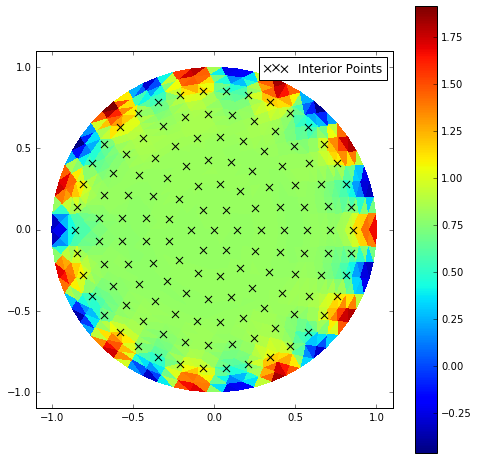

In [204]:
plot_circle(test_pts[:,0], test_pts[:,1], mu)

In [215]:
# now need to construct the thingy we are proposing over.
# Put a basis function at each point in the domain and iterate over them
proposal_length_scale = 0.2
k_proposal = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*proposal_length_scale**2)) 

# jointly proposing over the function and its derivatives wrt x and y.
# ironically constructing this is very similar to constructing our kernel matrix
Identity = lambda k: k
d1 = lambda k: k.diff(x_1)
d2 = lambda k: k.diff(x_2)
d1_bar = lambda k: k.diff(y_1)
d2_bar = lambda k: k.diff(y_2)

proposal_obs = [
    (field_pts, None),
    (field_pts, None),
    (field_pts, None)
]

proposal_op_cache = bpdes.generate_op_cache([Identity, d1, d2], [Identity, d1_bar, d2_bar], k_sqexp, [[x_1, x_2], [y_1, y_2]])
kern_mat = bpdes.collocation.calc_LLbar([Identity, d1, d2], [Identity, d1_bar, d2_bar], proposal_obs, proposal_op_cache)

In [216]:
new = np.random.multivariate_normal(np.zeros(kern_mat.shape[0]), kern_mat)
update_kappas(new)

In [217]:
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache) 
mu_1, _ = posterior(test_pts)

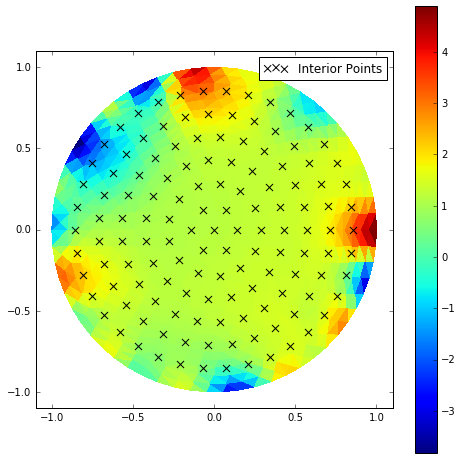

In [218]:
plot_circle(test_pts[:,0], test_pts[:,1], mu_1)

In [224]:
# is there a units issue with normalising voltage here?
true_x = bdy
#currents = [e[0] for e in experiments]
#voltages = [e[1] for e in experiments]
#volt_mean = np.asarray(voltages).mean()
#volt_std = np.asarray(voltages).std()
currents = true_currents
voltages = true_voltages
volt_mean = 0.
volt_std = 1.

In [225]:
from bayesian_pdes.problems import eit
reload(eit)
matrix_computer = eit.FastEITMatrixComputer(interior, bdy, true_x, k_sqexp, [[x_1, x_2], [y_1, y_2]])
class FastOpCache(object):
    def __init__(self, kappa, kappa_x, kappa_y):
        self.__kappa = kappa
        self.__kappa_x = kappa_x
        self.__kappa_y = kappa_y
        
    def __getitem__(self, item):
        if item == (A, A_bar):
            return lambda x,y: matrix_computer.AAbar(self.__kappa, self.__kappa_x, self.__kappa_y)
        if item == (B, B_bar):
            return lambda x,y: matrix_computer.BBbar(self.__kappa, self.__kappa_x, self.__kappa_y)
        if item == (A,B_bar):
            return lambda x,y: matrix_computer.ABbar(self.__kappa, self.__kappa_x, self.__kappa_y)
        if item == (B,A_bar):
            return lambda x,y: matrix_computer.ABbar(self.__kappa, self.__kappa_x, self.__kappa_y).T
        return op_cache[item]

In [238]:
from scipy import stats, linalg
(u, s, v) = np.linalg.svd(kern_mat)
def propose(current):
    xi = np.dot(np.random.normal(size=kern_mat.shape[0]), np.sqrt(s)[:, None] * v)
    #xi = np.random.multivariate_normal(np.zeros_like(current), kern_mat)
    new = np.sqrt(1-beta**2)*current + beta*xi
    return new
    
def potential(proposal):
    # potential is the negative log-likelihood
    return -log_likelihood(proposal)
def log_likelihood(proposal, debug=False):
    # ugly and dirty and horrid
    update_kappas(proposal)
    kappa = proposal[:len(field_pts)]
    kappa_x = proposal[len(field_pts):2*len(field_pts)]
    kappa_y = proposal[2*len(field_pts):3*len(field_pts)]
    oc = FastOpCache(kappa, kappa_x, kappa_y)
    #oc = op_cache
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc)
    mu_mult, cov = posterior.no_obs_posterior(true_x)
    cov_with_error = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    cov_with_error_inv = np.linalg.inv(cov_with_error)
    if debug:
        plt.matshow(cov_with_error); plt.colorbar()
    
    ret = 0
    for c, v in zip(currents, voltages):
        g = np.concatenate([interior_obs, c])
        true_u = (v.ravel() - volt_mean) / volt_std
        true_u = true_u.reshape((len(true_u), 1))
        mu = mu_mult.dot(g).reshape(true_u.shape)
        
        # todo: some inefficiency here - inverting cov multiple times
        this_lik = stats.multivariate_normal.logpdf(true_u.ravel(), mu.ravel(), cov_with_error, False)
        #this_lik = -(mu-true_u).T.dot(cov_with_error_inv).dot(mu-true_u)
        #print np.mean(true_u - mu), this_lik
        ret += this_lik
    return ret

In [240]:
import time, datetime
start_time = 0.
def reset():
    return time.time()
def update(it, n_it, str):
    if it == 0: return
    cur_time = time.time()
    remaining = datetime.timedelta(seconds=(cur_time - start_time) * (n_it-it) * 1./it)
    print 'Iter {}: {} (ETR: {})'.format(it, str, remaining) 

In [249]:
beta = 0.05
likelihood_sigma = 1e-4
start_time = reset()
update_frequency = 1000

In [259]:
from mcmc import pcn
reload(pcn)
kappas = pcn.pCN(int(1e5), propose, potential, true_fun, update_fun=update)

Iter 1000: Ratio 33% (ETR: 8 days, 3:24:44.903777)
Iter 2000: Ratio 21% (ETR: 4 days, 4:01:06.825047)
Iter 3000: Ratio 13% (ETR: 2 days, 20:12:33.364251)
Iter 4000: Ratio 12% (ETR: 2 days, 4:14:53.418789)
Iter 5000: Ratio 12% (ETR: 1 day, 18:42:14.002128)
Iter 6000: Ratio 11% (ETR: 1 day, 12:17:09.079984)
Iter 7000: Ratio 10% (ETR: 1 day, 7:45:05.415995)
Iter 8000: Ratio 11% (ETR: 1 day, 4:18:29.062734)
Iter 9000: Ratio 11% (ETR: 1 day, 1:35:32.863408)
Iter 10000: Ratio 8% (ETR: 23:23:54.018897)
Iter 11000: Ratio 10% (ETR: 21:37:37.345224)
Iter 12000: Ratio 10% (ETR: 20:07:52.483907)
Iter 13000: Ratio 10% (ETR: 18:51:00.563954)
Iter 14000: Ratio 10% (ETR: 17:42:58.755238)
Iter 15000: Ratio 8% (ETR: 16:44:35.821945)
Iter 16000: Ratio 9% (ETR: 15:52:10.690060)
Iter 17000: Ratio 7% (ETR: 15:05:57.426918)
Iter 18000: Ratio 10% (ETR: 14:24:06.003989)
Iter 19000: Ratio 10% (ETR: 13:45:50.925927)
Iter 20000: Ratio 8% (ETR: 13:11:06.381068)
Iter 21000: Ratio 10% (ETR: 12:40:22.062562)
Iter 220

In [260]:
#print acceptances.sum() * 1./iterations
thin= 1
burn = 1000
max = -1
thinned_burned = kappas[burn:max:thin, :]
#plt.legend(loc=2, bbox_to_anchor=(1.05,1))

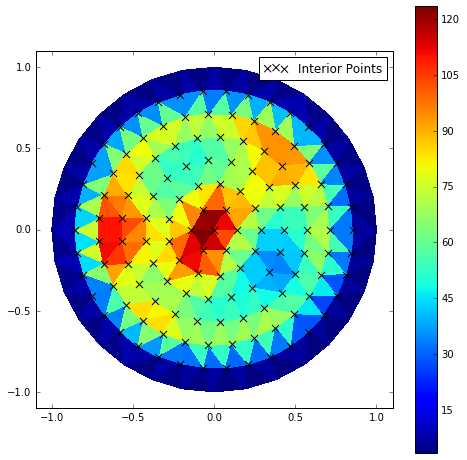

In [261]:
actual = np.mean(np.exp(thinned_burned), axis=0)

plot_circle(field_pts[:,0], field_pts[:,1], actual[:len(field_pts)])

In [258]:
print potential(actual)
print potential(true_fun)

579.116063319
-506.029518858


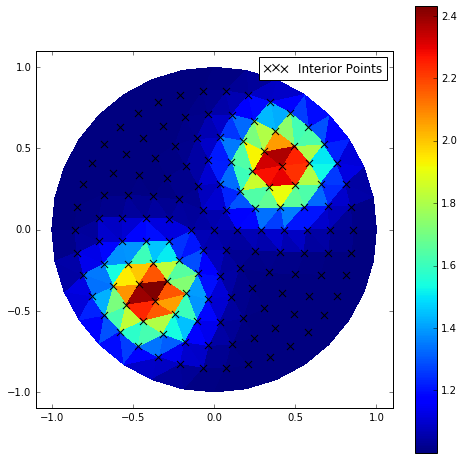

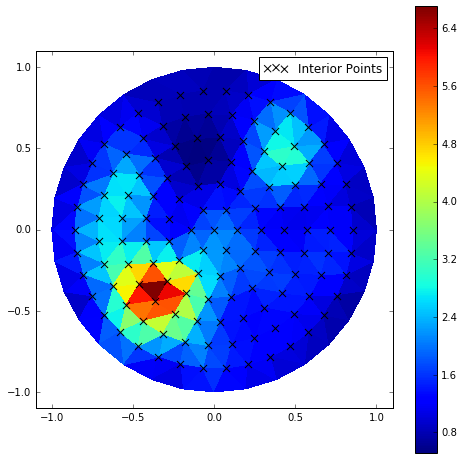

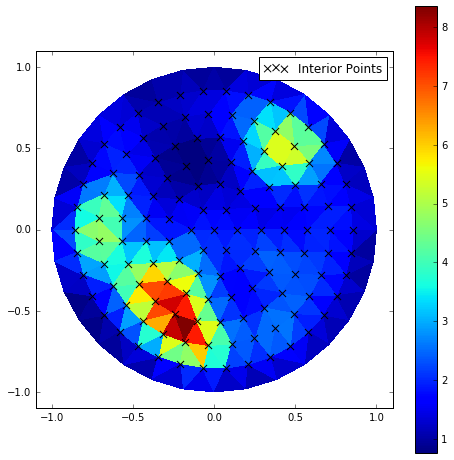

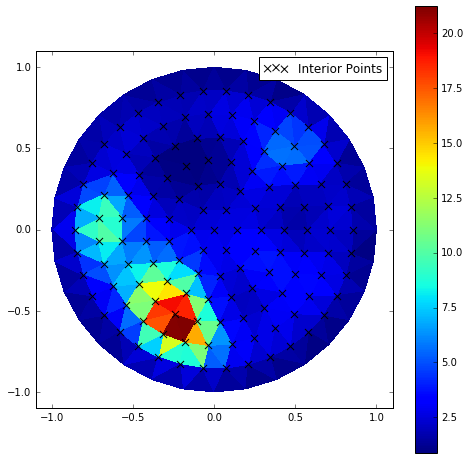

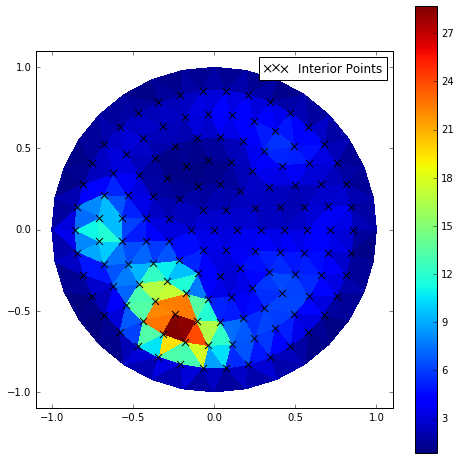

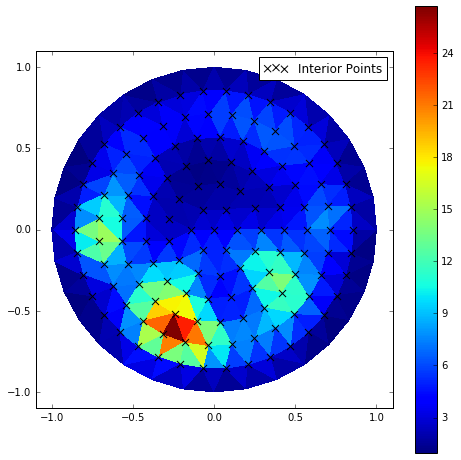

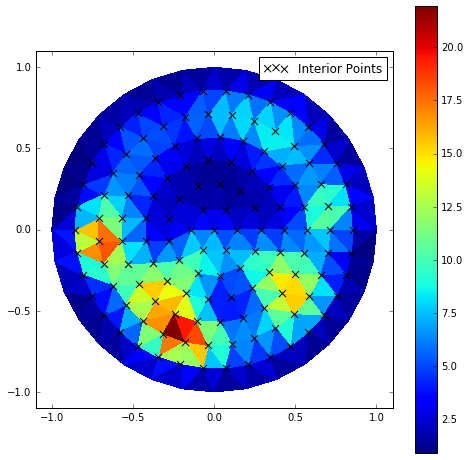

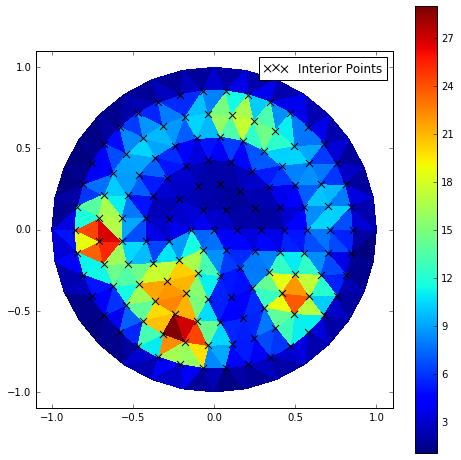

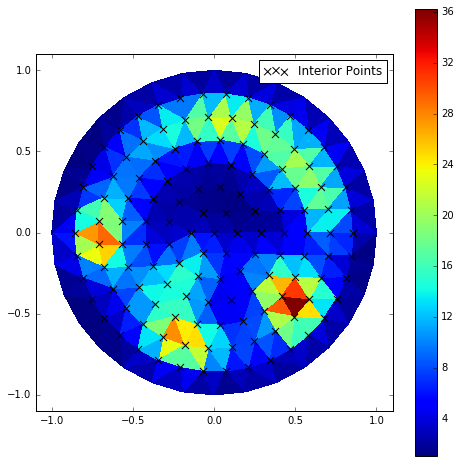

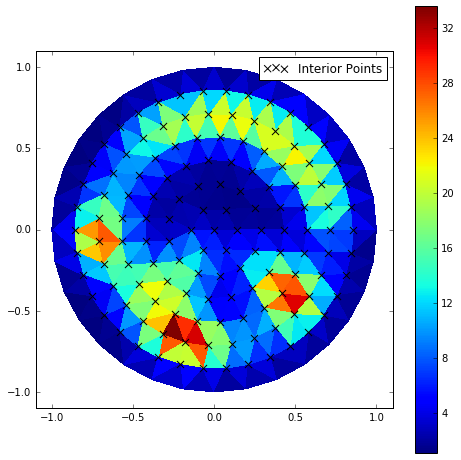

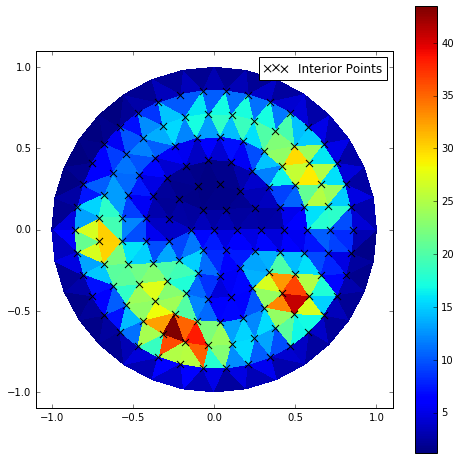

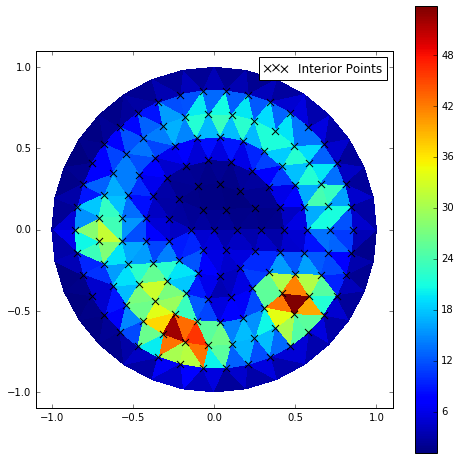

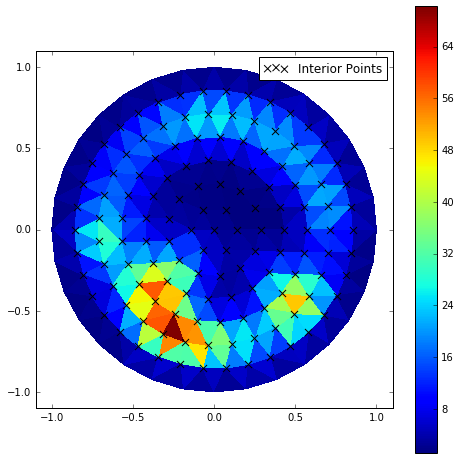

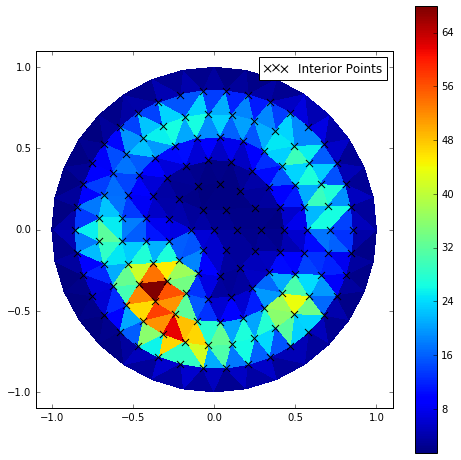

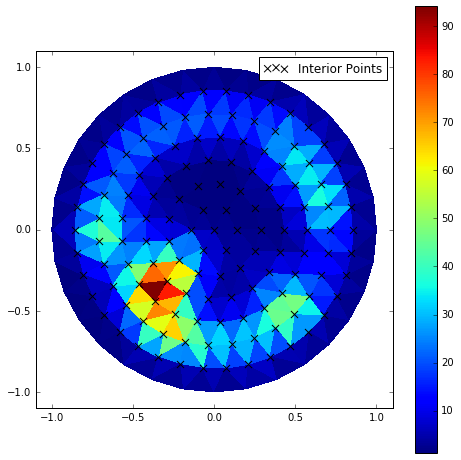

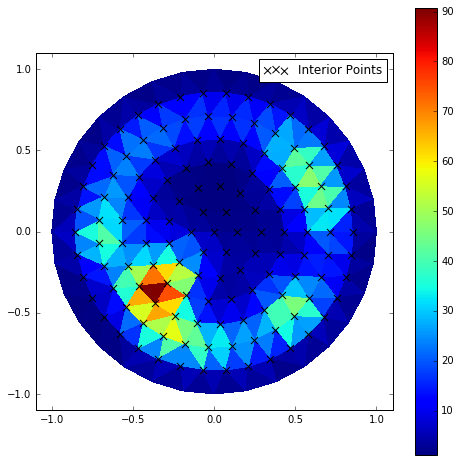

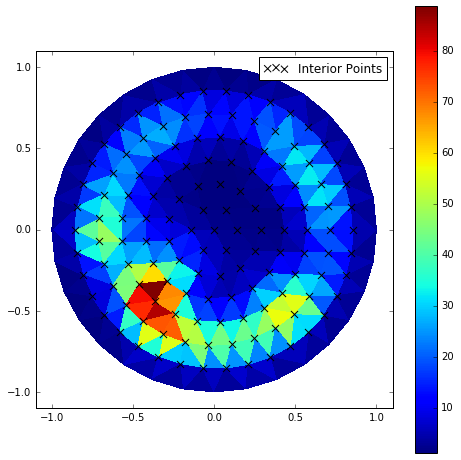

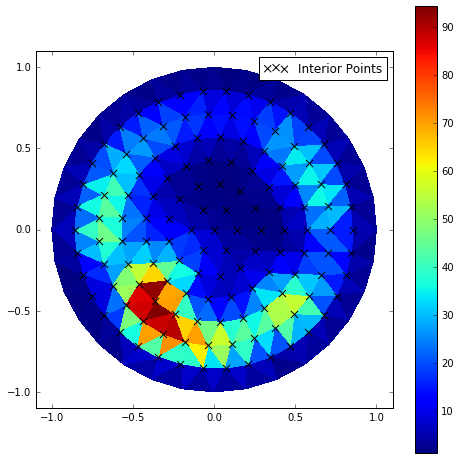

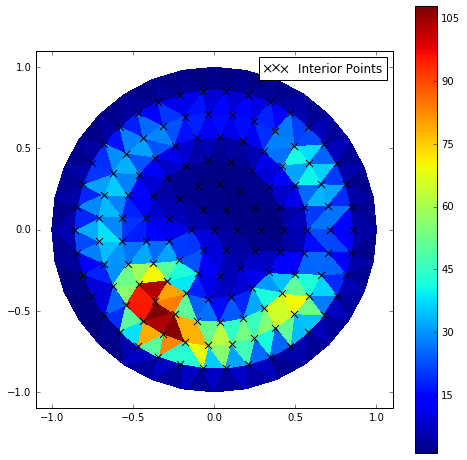

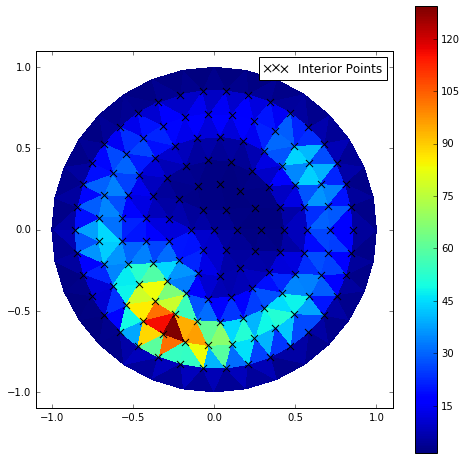

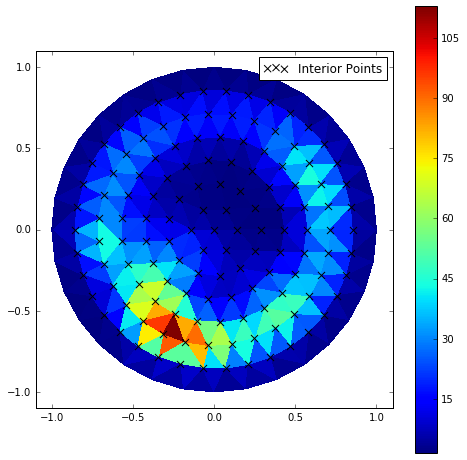

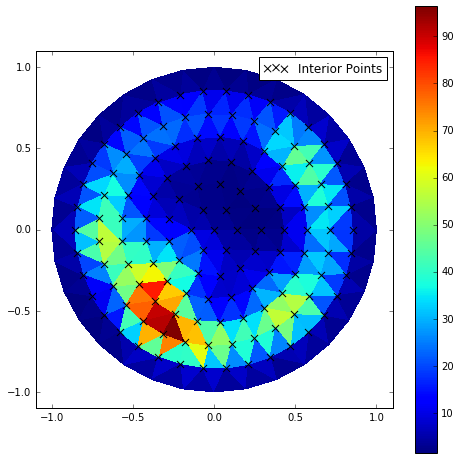

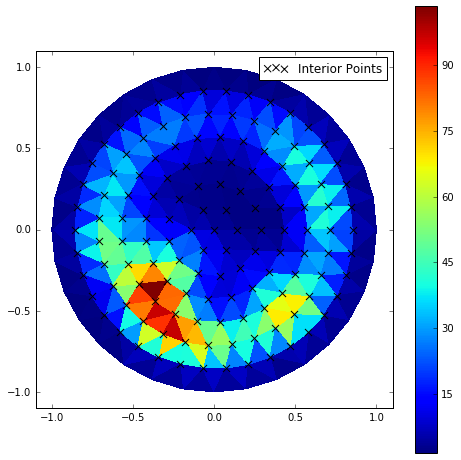

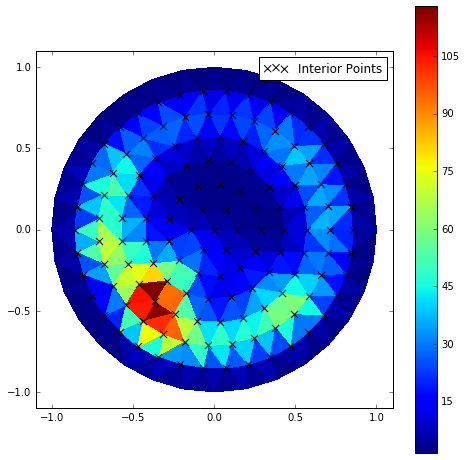

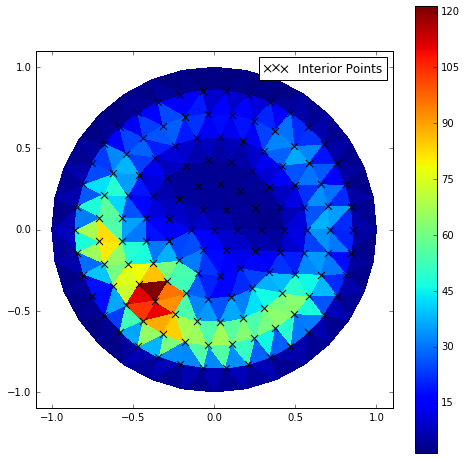

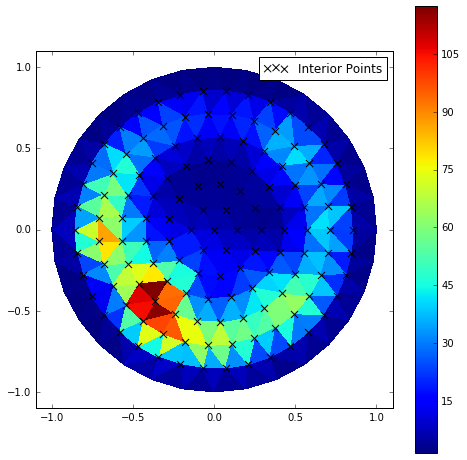

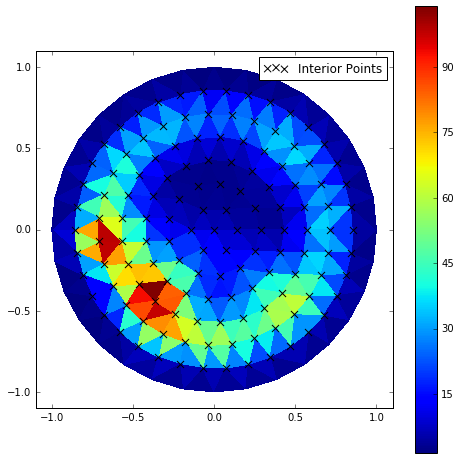

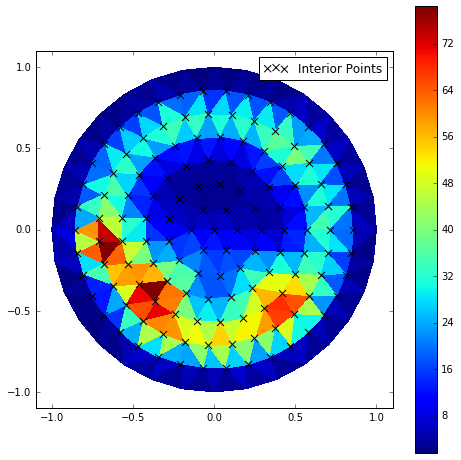

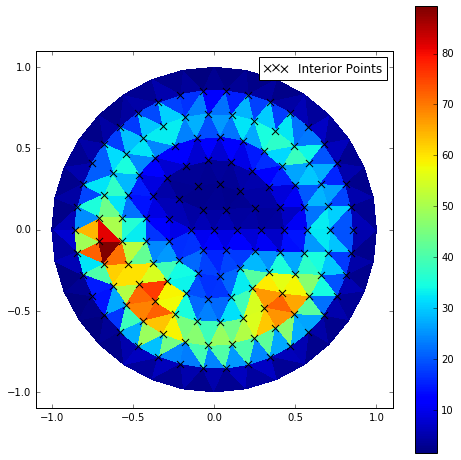

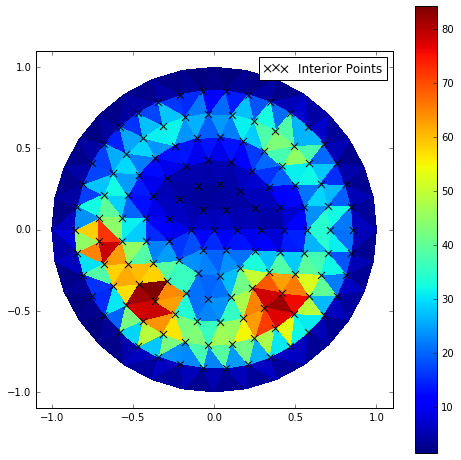

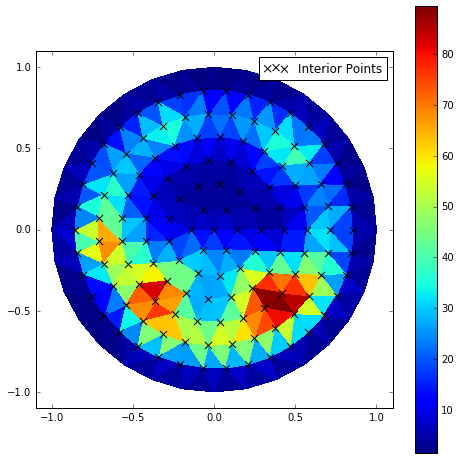

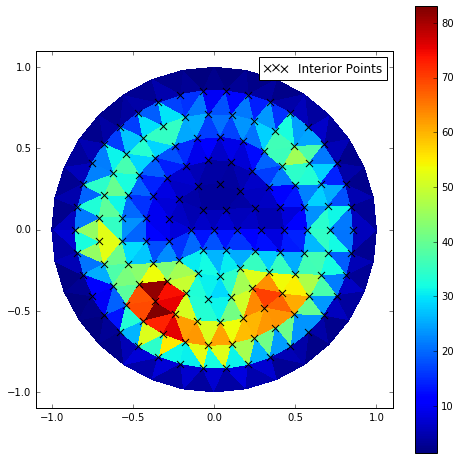

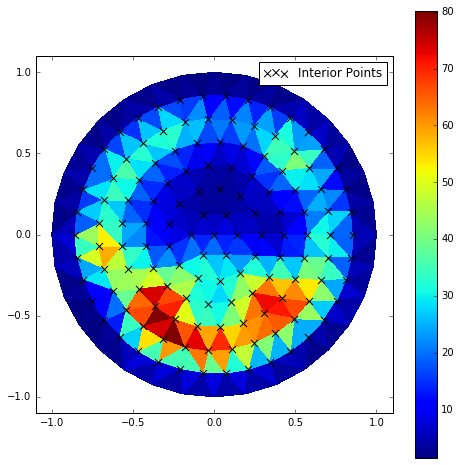

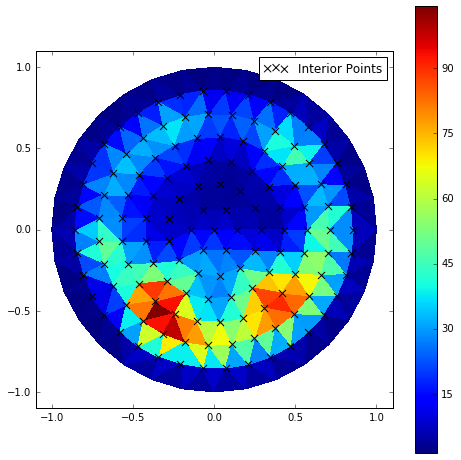

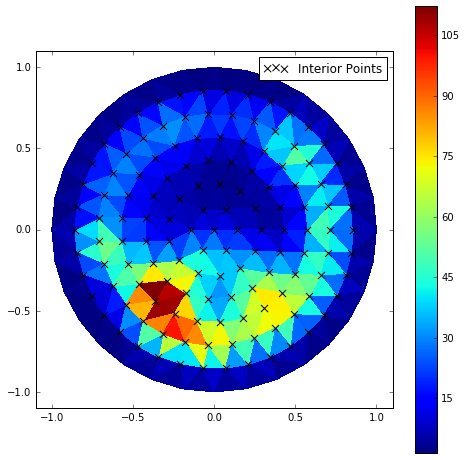

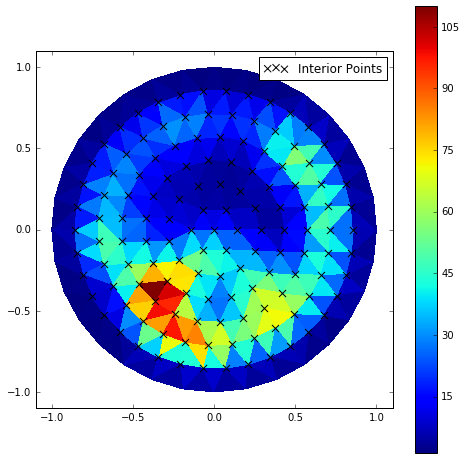

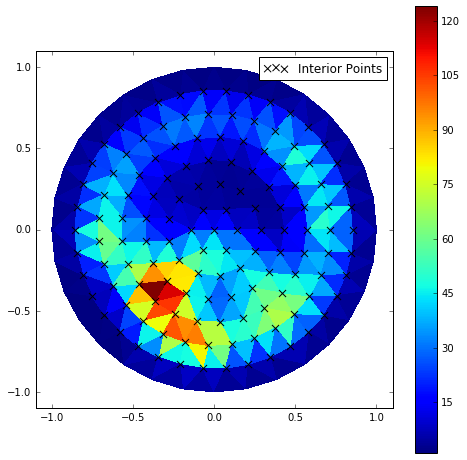

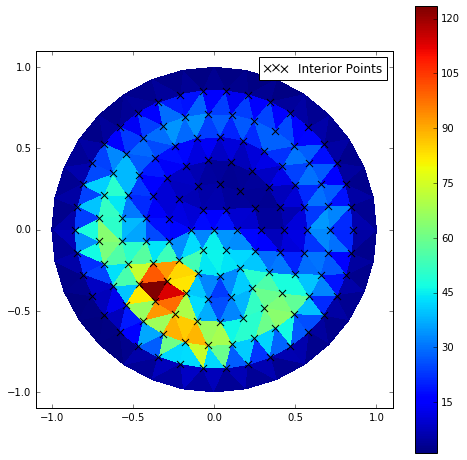

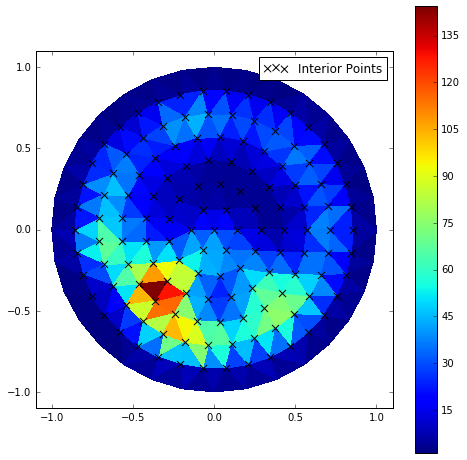

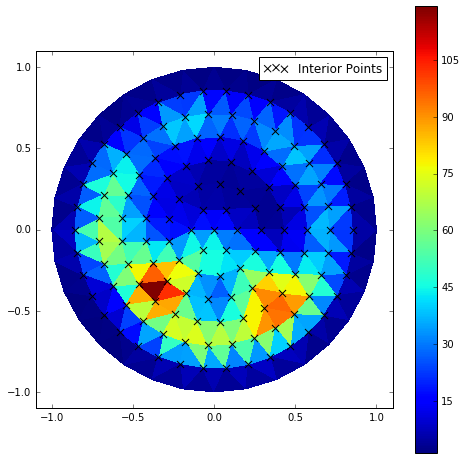

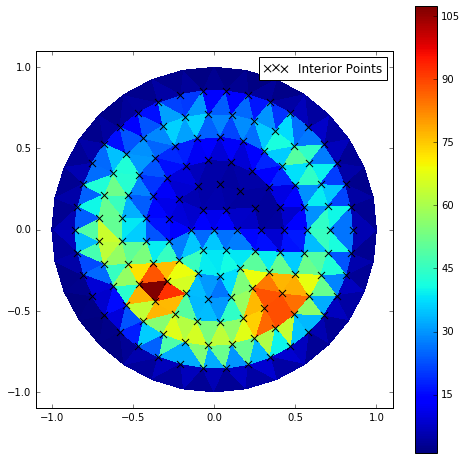

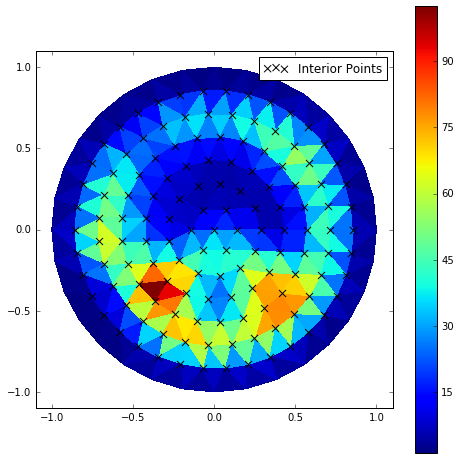

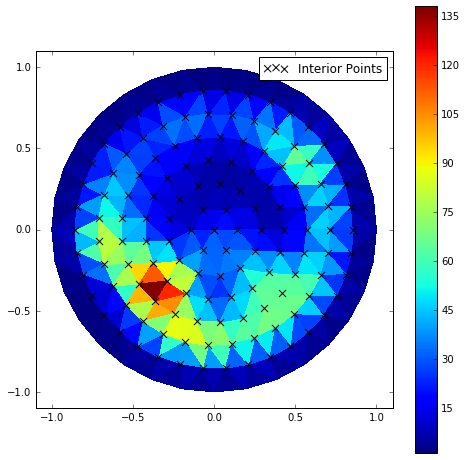

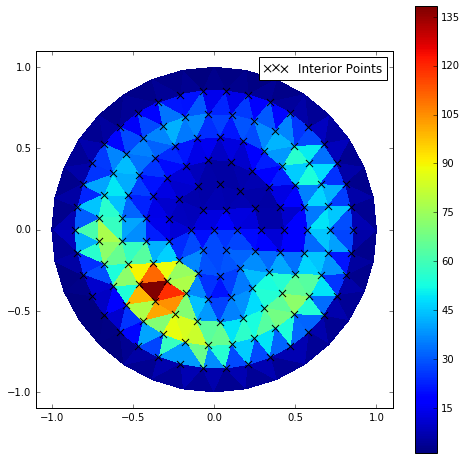

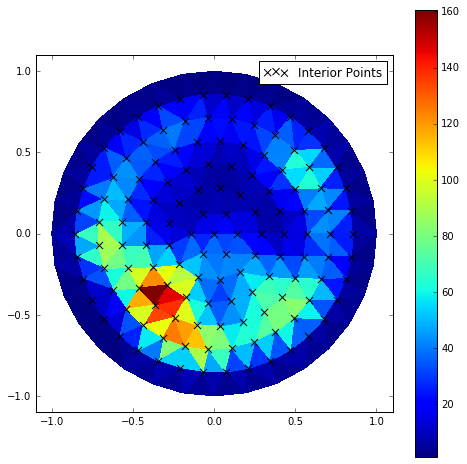

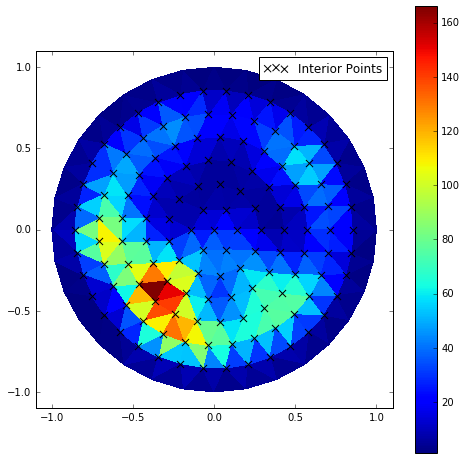

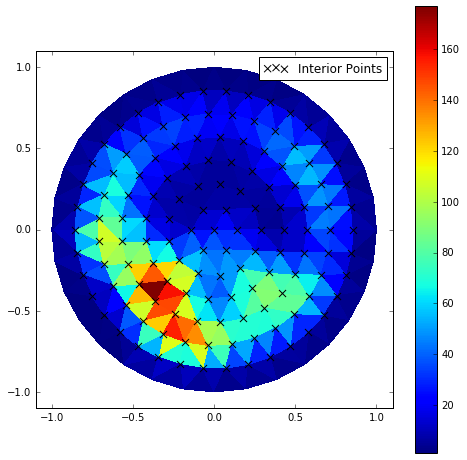

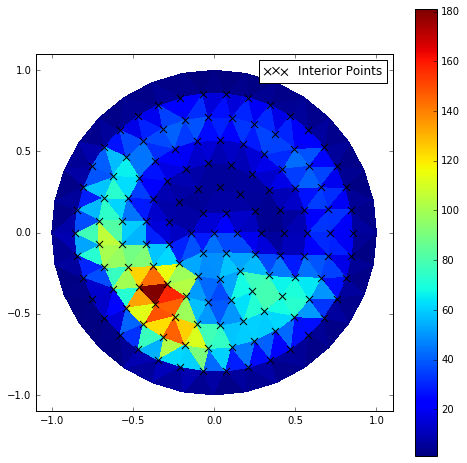

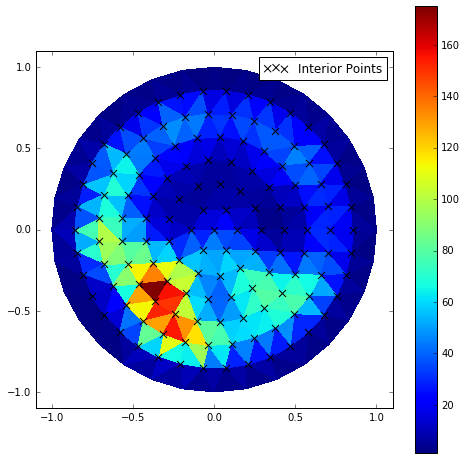

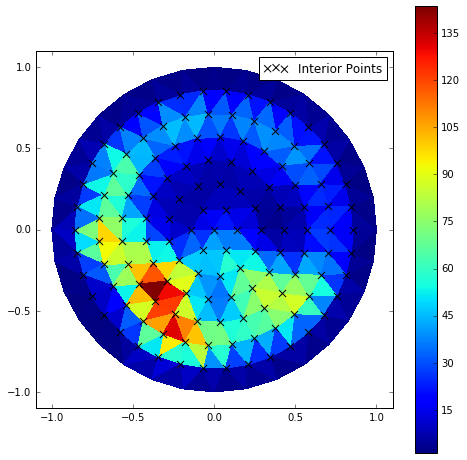

In [255]:
for i in range(0,5000,100):
    plot_circle(field_pts[:,0], field_pts[:,1], np.exp(kappas[i,:len(field_pts)]))
    plt.show(); plt.close()

In [ ]:
plot_circle()

In [92]:
cur_phi = potential(true_fun)
for i in xrange(5000):
    new_phi = potential(kappas[i,:])
    print new_phi, cur_phi, np.exp(cur_phi - new_phi)
    cur_phi = new_phi

[[ 0.6599816]] [[  9.19946912e-27]] [[ 0.51686085]]
[[ 0.6599816]] [[ 0.6599816]] [[ 1.]]
[[ 0.6599816]] [[ 0.6599816]] [[ 1.]]
[[ 0.6599816]] [[ 0.6599816]] [[ 1.]]
[[ 0.87305923]] [[ 0.6599816]] [[ 0.8080934]]
[[ 0.93339344]] [[ 0.87305923]] [[ 0.94144984]]
[[ 0.93339344]] [[ 0.93339344]] [[ 1.]]
[[ 0.86674228]] [[ 0.93339344]] [[ 1.06892254]]
[[ 0.99422754]] [[ 0.86674228]] [[ 0.88030639]]
[[ 1.18514639]] [[ 0.99422754]] [[ 0.82619962]]
[[ 1.18514639]] [[ 1.18514639]] [[ 1.]]
[[ 1.04754816]] [[ 1.18514639]] [[ 1.14751443]]
[[ 1.04754816]] [[ 1.04754816]] [[ 1.]]
[[ 1.34328698]] [[ 1.04754816]] [[ 0.74398171]]
[[ 1.21958843]] [[ 1.34328698]] [[ 1.13167468]]
[[ 1.7228747]] [[ 1.21958843]] [[ 0.60454071]]
[[ 1.7228747]] [[ 1.7228747]] [[ 1.]]
[[ 2.33712545]] [[ 1.7228747]] [[ 0.54104612]]
[[ 2.72897494]] [[ 2.33712545]] [[ 0.67580582]]
[[ 2.72897494]] [[ 2.72897494]] [[ 1.]]
[[ 2.72897494]] [[ 2.72897494]] [[ 1.]]
[[ 3.34029287]] [[ 2.72897494]] [[ 0.54263524]]
[[ 3.71628539]] [[ 3.340

KeyboardInterrupt: 

In [45]:
log_likelihood(true_fun)

array([[ -9.19944460e-27]])

# attempt to make a dummy diffusivity field

In [220]:
true_kappa = sp.exp(-((x_1 - 0.4)**2 + (x_2 - 0.4)**2) / (2*0.2**2)) + sp.exp(-((x_1 + 0.4)**2 + (x_2 + 0.4)**2) / (2*0.2**2))
true_kappa_dx1 = true_kappa.diff(x_1)
true_kappa_dx2 = true_kappa.diff(x_2)

true_kappa_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa))
true_kappa_dx1_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx1))
true_kappa_dx2_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx2))

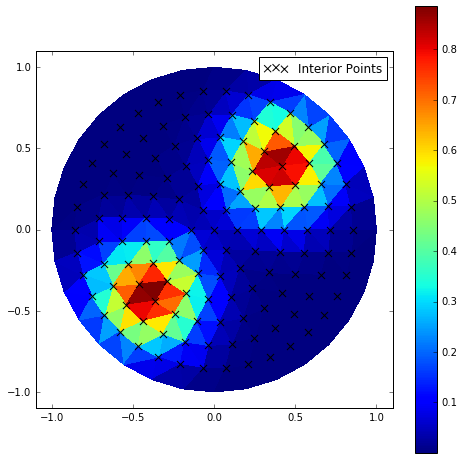

In [221]:
plot_circle(field_pts[:,0], field_pts[:,1], true_kappa_fun(field_pts[:,0], field_pts[:,1]))

In [222]:
true_fun = np.r_[
    true_kappa_fun(field_pts[:,0], field_pts[:,1]),
    true_kappa_dx1_fun(field_pts[:,0], field_pts[:,1]),
    true_kappa_dx2_fun(field_pts[:,0], field_pts[:,1])
]

In [223]:
true_currents = [e[0] for e in experiments]
true_voltages = []
update_kappas(true_fun)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache)
mu_mult, cov = posterior.no_obs_posterior(true_x)
for c in true_currents:
    g = np.concatenate([interior_obs, c])
    mu = mu_mult.dot(g)
    true_voltages.append(mu)